- By: Alex Kwon
- Email: alex.kwon [at] hudsonthames [dot] org
- Reference 1: [Online Portfolio Selection](https://books.google.com/books/about/Online_Portfolio_Selection.html?id=R2fdCgAAQBAJ) by Li and Hoi
- Reference 2: [On-Line Portfolio Selection Using Multiplicative Updates](http://web.cs.iastate.edu/~honavar/portfolio-selection.pdf) by Helmbold, Schapire, Singer, and Wurmuth

# Online Portfolio Selection - Momentum - Exponential Gradient

## Abstract

Momentum strategies have been a popular quantitative strategy in recent decades as the simple but powerful trend-following allows investors to exponentially increase their returns. This module will implement two types of momentum strategy with one following the best performing assets in the last period and the other following the BCRP's until the last period.

In this notebook, we will dive into Exponential Gradient, a momentum strategy that focuses on the best performing asset of the last time period. The portfolio shifts its weights to the best performing asset of the last period with an adjustment of $\eta$, the learning rate. A higher value of $\eta$ indicates the aggressiveness of the strategy to match the best performing assets. A lower value of $\eta$ indicates the passiveness of the strategy to match the best performing assets.

In traditional papers, $\eta$ of 0.05 was proved to be the most profitable strategy in the long run, and through this analysis, we find out that it is true for the datasets previous researchers have used. However, in the new data that I explored, I found that with the inclusion of a dominant asset and higher daily volatility, a higher eta value is necessary to follow the best stock. From the $\eta$ values explored, a value around 20 produced the best results that would follow the best performing asset and would not deviate too much with market noise.


**1. Exponential Gradient**
   - Multiplicative Update
   - Gradient Projection
   - Expectation Maximization
    
**2. Data Exploration**
   - NYSE: 1962-1984
   - DJIA: 2001-2003
   - TSE: 1994-1998
   - SP500: 1998-2003
   - MSCI: 1993-2020
   - US Equity: 2011-2020

# Strategy

Throughout the next couple weeks, we will be releasing notebooks on the following strategies

[**Benchmarks**](https://github.com/hudson-and-thames/research/blob/master/Online%20Portfolio%20Selection/Introduction%20to%20Online%20Portfolio%20Selection.ipynb)
- Buy and Hold
- Best Stock
- Constant Rebalanced Portfolio
- Best Constant Rebalanced Portfolio

**Momentum**
- Exponential Gradient
- Follow the Leader
- Follow the Regularized Leader

**Mean Reversion**
- Anti-Correlation
- Passive Aggressive Mean Reversion
- Online Moving Average Reversion
- Robust Median Mean Reversion

**Pattern Matching**
- Nonparametric Histogram/Kernel-Based/Nearest Neighbor Log-Optimal
- Correlation Driven Nonparametric Learning
- Nonparametric Kernel-Based Semi-Log-Optimal/Markowitz/GV

**Meta Algorithm**
- Aggregating Algorithm
- Fast Universalization Algorithm
- Online Gradient Updates
- Online Newton Updates
- Follow the Leading History

**Universal Portfolio**
- Universal Portfolio
- CORN-U
- CORN-K
- SCORN-K
- FCORN-K

In [6]:
import pandas as pd
import numpy as np
import pickle
import optuna
import matplotlib.pyplot as plt
from mlfinlab.online_portfolio_selection import *
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "svg" # Toggle for GitHub rendering

## Import Data

More information on these datasets is available [here].

In [3]:
msci = pd.read_csv('data/MSCI.csv', parse_dates=True, index_col='Date').dropna()[1:]
us_equity = pd.read_csv('data/US_Equity.csv', parse_dates=True, index_col='Date')
djia = pd.read_csv('data/DJIA.csv', parse_dates=True, index_col='Date')
nyse = pd.read_csv('data/NYSE.csv', parse_dates=True, index_col='Date')
sp500 = pd.read_csv('data/SP500.csv', parse_dates=True, index_col='Date')
tse = pd.read_csv('data/TSE.csv', parse_dates=True, index_col='Date')

## 1. Exponential Gradient

Exponential Gradient strategies focus on the following optimization problem that tracks the best performing stock with a learning rate, $\eta$, but also regularizes the new portfolio weight to prevent drastic changes from the previous portfolio.

$b_{t+1} = \underset{b \in \Delta_m}{\arg\max} \: \eta \log b \cdot x_t - R(b,b_t)$

### 1.1 Multiplicative Update 

Helmbold proposed a regularization term that adopts relative entropy.

$R(b,b_t) = \overset{m}{\underset{i=1}{\sum}}b_i \log \frac{b_i}{b_{t,i}}$

    
Using log's first order taylor expansion of $b_i$

$\log b \cdot x_t \approx \log(b_t \cdot x_t) + \frac{x_t}{b_t \cdot x_t}(b-b_t)$

Multiplicative update algorithm can be stated as the following
    
$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right)$

If we adopt relative entropy as the regularization factor, we can use the log's first order taylor expansion to create an update rule to be the following multiplicative one.

$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right) / Z$, where $Z$ is a normalization term to sum the weights to 1

### 1.2 Gradient Projection

Instead of relative entropy, gradient projection adopts an L2-regularization term for the optimization equation.

$R(b,b_t) = \frac{1}{2}\overset{m}{\underset{i=1}{\sum}}(b_i - b_{t,i})^2$

This regularization term can be transcribed to the following update rule

$b_{t+1} = b_t + \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - \frac{1}{m} \sum_{j=1}^{m} \frac{x_t}{b_t \cdot x_t} \right)$

### 1.3 Expectation Maximization

Expectation Maximization uses a $\chi^2$ regularization term

$R(b-b_t)=\frac{1}{2}\overset{m}{\underset{i=1}{\sum}}\frac{(b_i - b_{t,i})^2}{b_{t,i}}$

Then, the corresponding update rule becomes

$b_{t+1} = b_t \cdot \left( \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - 1 \right) + 1 \right)$

Each of these update rules can be called using the **ExponentialGradient()** with different update rules with the default being multiplicative updates.

Learning rates can also be adjusted by setting **eta**, and if no values are stated default will be 0.05

- Multiplicative Update: ExponentialGradient('MU', eta=0.05)
- Gradient Projection: ExponentialGradient('GP', eta=0.1)
- Expectation Maximization: ExponentialGradient('EM', eta=1)

## 2.1 NYSE: 1961-1984

We'll first look at the dataset covered by Thomas Cover's original Universal Portfolio.

Most of the stocks increased during this period with Philips Morris increasing by more than 53 times.

#### Best Stock Analysis

In [5]:
nyse_beststock = BestStock()
nyse_beststock.allocate(nyse)
display(nyse_beststock.all_weights.iloc[-1].to_frame().T)
display(nyse.iloc[-1].to_frame().T)

,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
1984-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
1984-12-31,13.103622,4.347081,16.100538,16.902053,13.357385,52.020292,8.760266,3.065435,13.707717,14.15607,...,14.430813,5.979156,15.214815,54.140364,6.975924,16.204888,43.128665,4.24545,6.537269,5.388037


We will be dividing the parameters into two sets. The first will be a "small" set that looks at parameter values between 0 and 1. The second will be a "large" set that looks at parameter values between 1 and 100. I used the optuna package to find the ideal hyperparameter for Expectation Gradient and pickled the objects.

In [14]:
data = 'NYSE'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    nyse_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    nyse_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    nyse_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    nyse_large_eta_optuna = pickle.load(f)

#### Hyperparameter Tuning

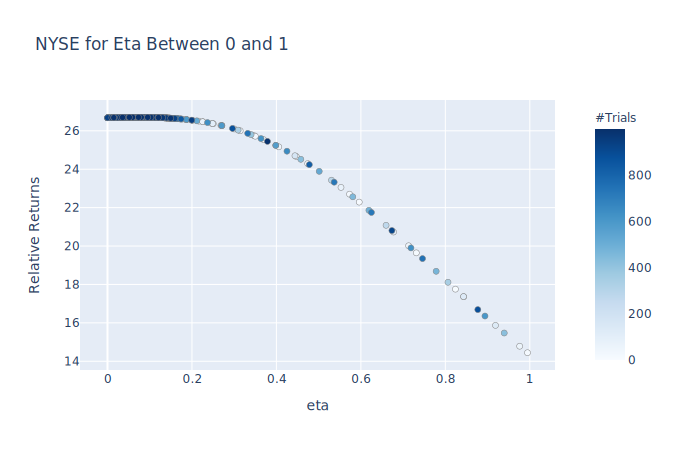

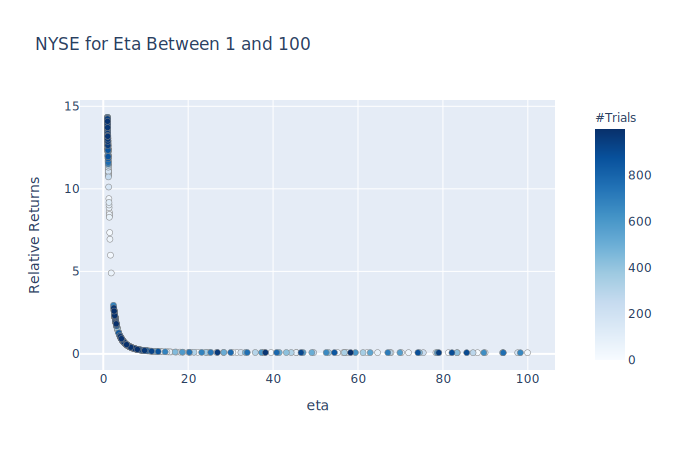

In [40]:
fig = optuna.visualization.plot_slice(nyse_small_eta_optuna)
fig.update_layout(title_text="NYSE for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
display(fig)
fig = optuna.visualization.plot_slice(nyse_large_eta_optuna)
fig.update_layout(title_text="NYSE for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
display(fig)

#### Best Parameters

In [56]:
print("Best parameter: ", nyse_small_eta_optuna.best_params['eta'])
print("Best returns: ", nyse_small_eta_optuna.best_trial.value)
print("Best trial number: ", nyse_small_eta_optuna.best_trial.number)

Best parameter:  0.07364226809952339
Best returns:  26.706310066442498
Best trial number:  397


Results for this data indicate similar findings as Helmbold's. $\eta$ of 0.05 was proposed as an ideal parameter, and through our tuning, we found that our best parameter, 0.0736, was very close to the original dataset.

#### Benchmarks Comparison

In [57]:
nyse_bah = BuyAndHold()
nyse_bah.allocate(nyse)

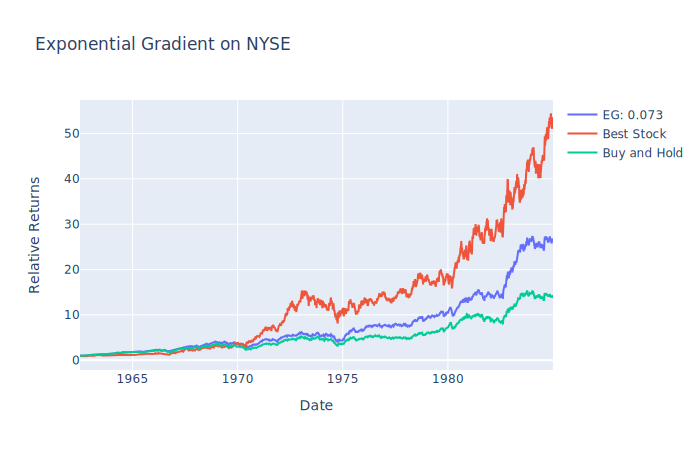

In [58]:
fig = go.Figure(); idx = nyse_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=nyse_small_eta_list[397].portfolio_return['Returns'], name="EG: 0.073"))
fig.add_trace(go.Scatter(x=idx, y=nyse_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=nyse_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.update_layout(title='Exponential Gradient on NYSE', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

A simple buy and hold returned 12, whereas the best performing Exponential Gradient returned 26.7.

For a dataset where all stocks increase in prices, a low EG value is suitable for higher results. Because not one stock goes down, most strategy would work in the long term. A uniform weight was adequate for this 20 year period, and the low eta value supported this maximum portfolio returns.

#### Change in Weights

In [178]:
display(nyse_small_eta_list[397].all_weights.head(2))
display(nyse_small_eta_list[397].all_weights.tail(2))

,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
Date,,,,,,,,,,,,,,,,,,,,,
1962-07-03,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,...,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778
1962-07-05,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,...,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778


,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
Date,,,,,,,,,,,,,,,,,,,,,
1984-12-28,0.026967,0.025214,0.027317,0.027910,0.027024,0.032716,0.026278,0.024081,0.033563,0.026896,...,0.027143,0.025355,0.027679,0.030062,0.025587,0.027869,0.029860,0.024814,0.026381,0.025393
1984-12-31,0.026944,0.025218,0.027308,0.027918,0.027031,0.032718,0.026260,0.024096,0.033598,0.026904,...,0.027148,0.025341,0.027679,0.030087,0.025574,0.027865,0.029879,0.024791,0.026426,0.025391


The value of $\eta$ strongly affects our changes in weights. A low value of eta explored in this data indicates minimal deviation. The results at the end are almost similar to what we would expect from a simple buy and hold strategy.

## 2.2 DJIA: 2001-2003

This DJIA set covers a bear market run with most companies losing value.

In [59]:
djia.tail(3)

,Alcoa,GE,Johnson&Johnson,Microsoft,American Express,General Motors,JP Morgan Chase,P&G,Boeing,Home Depot,...,DuPont,IBM,Philip Morris,Walmart,Walt Disney,Intel,Merck,ExxonMobil,Eastman Kodak,International Paper
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-10,0.697461,0.536499,1.158364,1.166458,0.682517,0.713556,0.535059,1.154093,0.541081,0.419518,...,0.918440,0.926556,0.975148,0.883299,0.584353,0.508910,0.671042,0.826648,0.993581,0.916951
2003-01-13,0.699602,0.536289,1.134872,1.176262,0.688953,0.725050,0.538811,1.154897,0.548274,0.426905,...,0.912182,0.924760,0.979408,0.877481,0.589183,0.507742,0.670930,0.823364,0.986421,0.923770
2003-01-14,0.708474,0.537753,1.141353,1.188361,0.686986,0.738916,0.544934,1.157175,0.545876,0.428655,...,0.917814,0.936067,0.978698,0.879706,0.594656,0.519720,0.671042,0.830870,0.987161,0.931076


#### Best Stock Analysis
The best performing stock was P&G for this period with 1.15 times the price for a 2-year range.

In [67]:
djia_beststock = BestStock()
djia_beststock.allocate(djia)
display(djia_beststock.all_weights.iloc[-1].to_frame().T)
display(djia.iloc[-1].to_frame().T)

,Alcoa,GE,Johnson&Johnson,Microsoft,American Express,General Motors,JP Morgan Chase,P&G,Boeing,Home Depot,...,DuPont,IBM,Philip Morris,Walmart,Walt Disney,Intel,Merck,ExxonMobil,Eastman Kodak,International Paper
2003-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Alcoa,GE,Johnson&Johnson,Microsoft,American Express,General Motors,JP Morgan Chase,P&G,Boeing,Home Depot,...,DuPont,IBM,Philip Morris,Walmart,Walt Disney,Intel,Merck,ExxonMobil,Eastman Kodak,International Paper
2003-01-14,0.708474,0.537753,1.141353,1.188361,0.686986,0.738916,0.544934,1.157175,0.545876,0.428655,...,0.917814,0.936067,0.978698,0.879706,0.594656,0.51972,0.671042,0.83087,0.987161,0.931076


In [61]:
data = 'DJIA'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    djia_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    djia_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    djia_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    djia_large_eta_optuna = pickle.load(f)

#### Hyperparameter Tuning

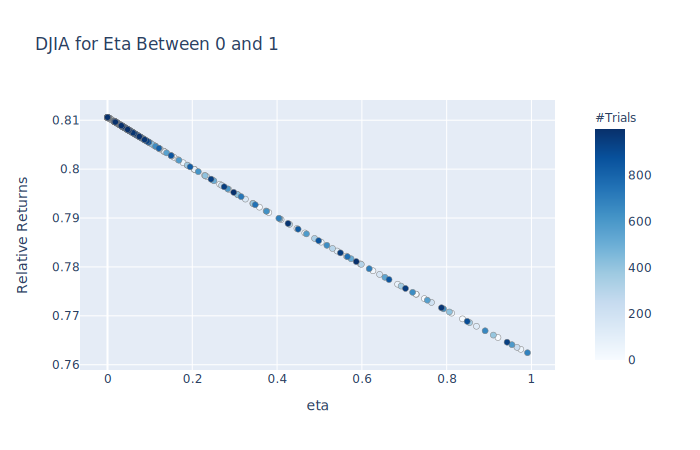

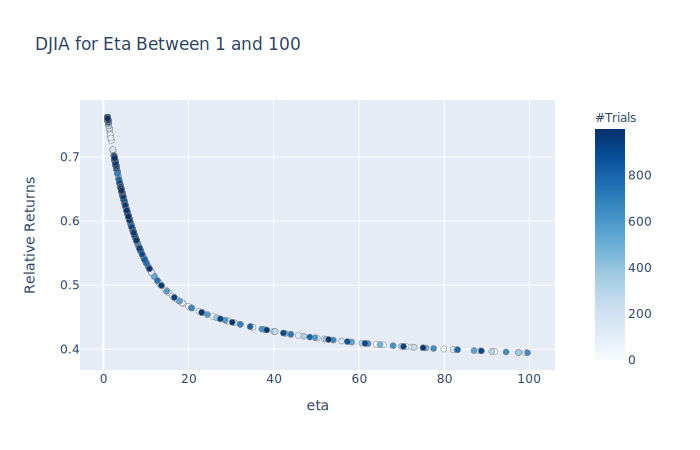

In [62]:
fig = optuna.visualization.plot_slice(djia_small_eta_optuna)
fig.update_layout(title_text="DJIA for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()
fig = optuna.visualization.plot_slice(djia_large_eta_optuna)
fig.update_layout(title_text="DJIA for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

It's not too surprising that most of our portfolio lost in value in the first place because our current problem formulation does not allow for short selling. Generally, all of the stocks decreased in values as well.

#### Best Parameters

In [64]:
print("Best parameter: ", djia_small_eta_optuna.best_params['eta'])
print("Best returns: ", djia_small_eta_optuna.best_trial.value)
print("Best trial number: ", djia_small_eta_optuna.best_trial.number)

Best parameter:  1.473309438842684e-06
Best returns:  0.8106059699948273
Best trial number:  736


The best parameter for this market was a value close to 0.

#### Benchmarks Comparison

In [65]:
djia_bah = BuyAndHold()
djia_bah.allocate(djia)
djia_bcrp = BestConstantRebalancedPortfolio()
djia_bcrp.allocate(djia)

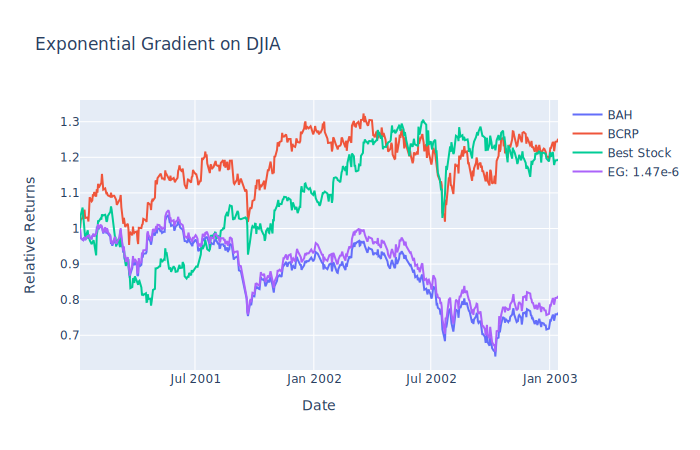

In [69]:
fig = go.Figure(); idx = djia_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=djia_bah.portfolio_return['Returns'], name="BAH"))
fig.add_trace(go.Scatter(x=idx, y=djia_bcrp.portfolio_return['Returns'], name="BCRP"))
fig.add_trace(go.Scatter(x=idx, y=djia_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=djia_small_eta_list[736].portfolio_return['Returns'], name="EG: 1.47e-6"))
fig.update_layout(title='Exponential Gradient on DJIA', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

For a market with a general downtrend, exponential gradient fails to make a significant effect on our returns. This is in line with the underlying concept for momentum where a strong trend in a direction is necessary to reap the rewards. In hindsight, the investors would have allocated their capital on P&G; however, even for P&G, there is a lot of movements that would have prohibited the strategy to capture the market direction.

## TSE: 1994-1998

TSE contains a good mix of companies that both lost and gained in prices over five years.

In [182]:
tse.tail(4)

,Westcoast Energy,Seagram,TVX Gold,Transcanada,Thomson,Talisman,Trilon,Teck,TD Bank,Transalta,...,Cott Corp,Bombardier,Anderson,AUR Resources,Alcan Aluminum,Agnico-Eagle Mines,Alberta Energy,Air Canada,Aber Resources,Barrick Gold Corp
Date,,,,,,,,,,,,,,,,,,,,,
1998-12-28,1.706694,1.729760,0.314291,1.431531,2.488814,0.906779,4.099141,0.495611,2.892180,2.021149,...,0.176781,4.412507,0.900356,0.442871,1.653653,0.366799,1.979006,1.229973,2.092211,0.813941
1998-12-29,1.706694,1.805627,0.310862,1.433421,2.482107,0.887815,4.043995,0.488853,2.969661,2.021149,...,0.164154,4.422568,0.928060,0.451729,1.651682,0.375819,1.967120,1.219974,2.144851,0.829015
1998-12-30,1.706694,1.744934,0.312006,1.423886,2.371417,0.886091,4.043995,0.473084,2.961358,2.007911,...,0.162575,4.312004,0.910745,0.442871,1.645769,0.378825,1.943347,1.219974,2.171168,0.811202
1998-12-31,1.717958,1.767688,0.308578,1.427061,2.408317,0.929191,4.043995,0.504624,2.977971,1.994673,...,0.172045,4.422563,0.962685,0.460586,1.635914,0.378825,1.961168,1.229977,2.263269,0.816685


#### Best Stock Analysis

The best performing stock in hindsight was Gentra with an increase to 6.279 during this period.

In [70]:
tse_beststock = BestStock()
tse_beststock.allocate(tse)
display(tse_beststock.all_weights.iloc[-1,40:60].to_frame().T)
display(tse.iloc[-1,40:60].to_frame().T)

,Moore Corp,Macmillan Bloedel,Miramar Mining Corp,Loewen Group,Kinross Gold,Imasco,Imperial Oil,Investors Group,Intl Forest Products,Hudson's Bay,Gentra,Gulf Canada,Franco-Nevada Mining Corp,Fletcher Challenge Canada,First Australia,Extendicare,Euro-Nevada Mining Corp,Canadian 88 Energy Corp,Echo Bay Mines,Domtar
1998-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Moore Corp,Macmillan Bloedel,Miramar Mining Corp,Loewen Group,Kinross Gold,Imasco,Imperial Oil,Investors Group,Intl Forest Products,Hudson's Bay,Gentra,Gulf Canada,Franco-Nevada Mining Corp,Fletcher Challenge Canada,First Australia,Extendicare,Euro-Nevada Mining Corp,Canadian 88 Energy Corp,Echo Bay Mines,Domtar
1998-12-31,0.820145,0.829264,0.226115,0.384622,0.830646,3.938255,2.108617,2.554517,0.167437,0.568515,6.27922,1.066768,1.390163,0.919368,1.32618,1.338604,2.145959,2.605324,0.159136,1.101088


In [71]:
data = 'TSE'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    tse_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    tse_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    tse_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    tse_large_eta_optuna = pickle.load(f)

#### Hyperparameter Tuning

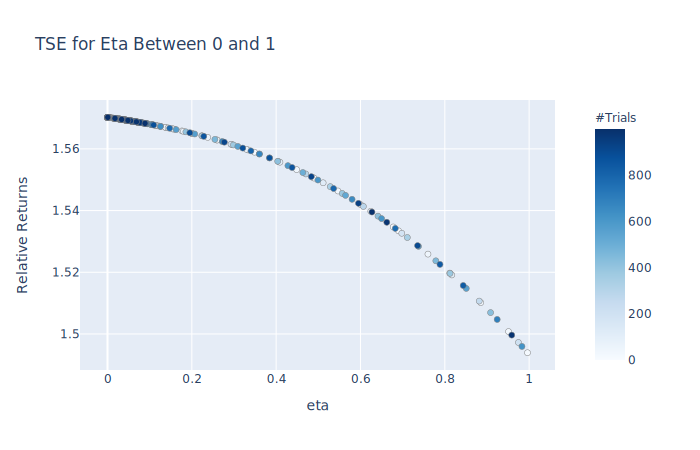

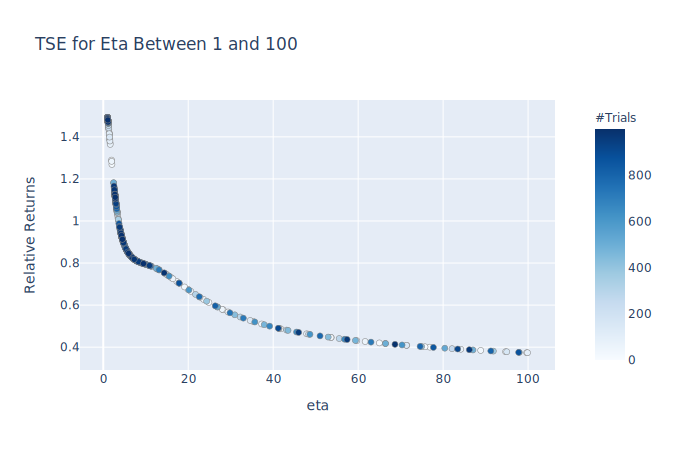

In [72]:
fig = optuna.visualization.plot_slice(tse_small_eta_optuna)
fig.update_layout(title_text="TSE for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()
fig = optuna.visualization.plot_slice(tse_large_eta_optuna)
fig.update_layout(title_text="TSE for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

#### Best Parameters

In [73]:
print("Best parameter: ", tse_small_eta_optuna.best_params['eta'])
print("Best returns: ", tse_small_eta_optuna.best_trial.value)
print("Best trial number: ", tse_small_eta_optuna.best_trial.number)

Best parameter:  2.612195774396946e-06
Best returns:  1.570249601140997
Best trial number:  264


In [74]:
tse_bah = BuyAndHold()
tse_bah.allocate(tse)
tse_bcrp = BestConstantRebalancedPortfolio()
tse_bcrp.allocate(tse)

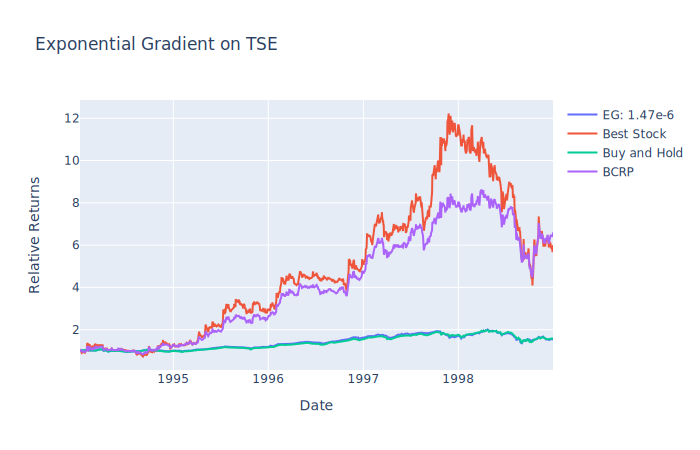

In [75]:
fig = go.Figure(); idx = tse_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=tse_small_eta_list[264].portfolio_return['Returns'], name="EG: 1.47e-6"))
fig.add_trace(go.Scatter(x=idx, y=tse_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=tse_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=tse_bcrp.portfolio_return['Returns'], name="BCRP"))
fig.update_layout(title='Exponential Gradient on TSE', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

The returns for Exponential Gradient are dwarfed by the returns posted by Best Stock or BCRP.

In a market with a lot of volatility and a presence of both increasing and decreasing stocks, exponential gradients are unable to capture the best weight allocation.

## SP500: 1998-2003

In [76]:
sp500.tail(3)

,GE,Microsoft,Walmart,ExxonMobil,Pfizer,Citigroup,Johnson & Johnson,AIG,IBM,Merck,...,Verizon,Wells Fargo,Amgen,Dell,PepsiCo,SBC Comms,Fannie Mae,Chevron,Viacom,Eli Lilly
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-29,0.933647,1.522519,2.443176,1.094143,1.210898,1.328937,1.610757,1.415379,1.520854,1.029315,...,0.828039,1.227103,3.870403,2.363139,1.125278,0.649074,1.125670,0.837851,1.898274,0.888341
2003-01-30,0.914188,1.471575,2.416255,1.074102,1.177603,1.278471,1.584321,1.359959,1.482605,1.012962,...,0.817483,1.213748,3.780669,2.255850,1.075278,0.636530,1.091298,0.823737,1.823463,0.861215
2003-01-31,0.938107,1.447781,2.427938,1.103840,1.203367,1.284079,1.647952,1.382178,1.480712,1.029315,...,0.841895,1.240458,3.779186,2.225996,1.124444,0.652276,1.111921,0.826304,1.860628,0.873835


#### Best Stock Analysis

In [77]:
sp500_beststock = BestStock()
sp500_beststock.allocate(sp500)
display(sp500_beststock.all_weights.iloc[-1].to_frame().T)
display(sp500.iloc[-1].to_frame().T)

,GE,Microsoft,Walmart,ExxonMobil,Pfizer,Citigroup,Johnson & Johnson,AIG,IBM,Merck,...,Verizon,Wells Fargo,Amgen,Dell,PepsiCo,SBC Comms,Fannie Mae,Chevron,Viacom,Eli Lilly
2003-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,GE,Microsoft,Walmart,ExxonMobil,Pfizer,Citigroup,Johnson & Johnson,AIG,IBM,Merck,...,Verizon,Wells Fargo,Amgen,Dell,PepsiCo,SBC Comms,Fannie Mae,Chevron,Viacom,Eli Lilly
2003-01-31,0.938107,1.447781,2.427938,1.10384,1.203367,1.284079,1.647952,1.382178,1.480712,1.029315,...,0.841895,1.240458,3.779186,2.225996,1.124444,0.652276,1.111921,0.826304,1.860628,0.873835


In [79]:
data = 'SP500'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    sp500_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    sp500_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    sp500_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    sp500_large_eta_optuna = pickle.load(f)

#### Hyperparameter Tuning

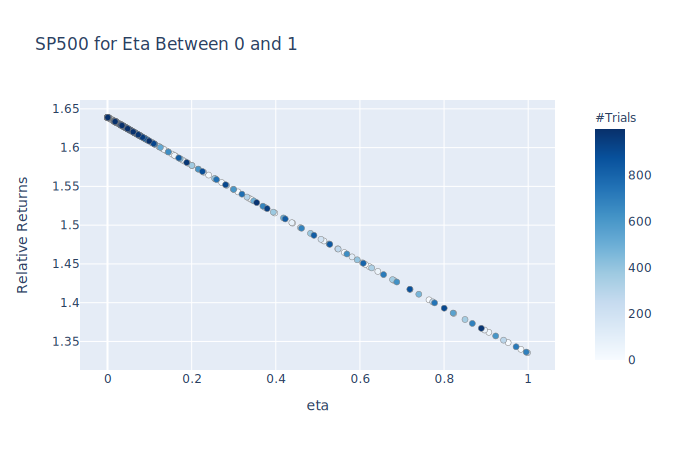

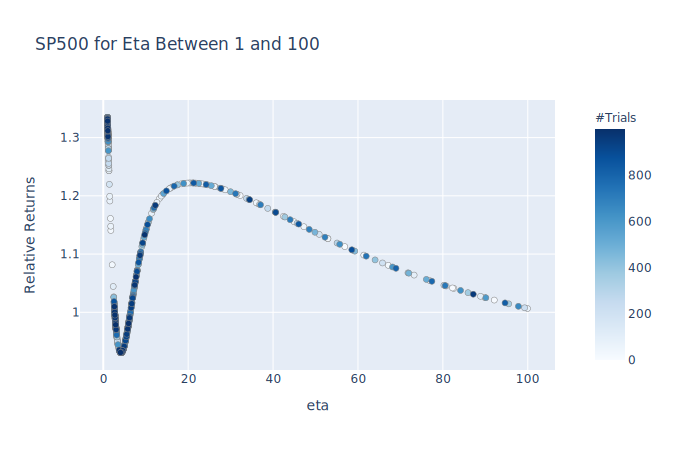

In [80]:
fig = optuna.visualization.plot_slice(sp500_small_eta_optuna)
fig.update_layout(title_text="SP500 for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()
fig = optuna.visualization.plot_slice(sp500_large_eta_optuna)
fig.update_layout(title_text="SP500 for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

#### Best Parameters

In [81]:
print("Best parameter: ", sp500_small_eta_optuna.best_params['eta'])
print("Best returns: ", sp500_small_eta_optuna.best_trial.value)
print("Best trial number: ", sp500_small_eta_optuna.best_trial.number)

Best parameter:  2.395215871893962e-06
Best returns:  1.6391662351711398
Best trial number:  152


#### Benchmarks Comparison

In [82]:
sp500_bah = BuyAndHold(); sp500_bah.allocate(sp500)
sp500_bcrp = BestConstantRebalancedPortfolio(); sp500_bcrp.allocate(sp500)

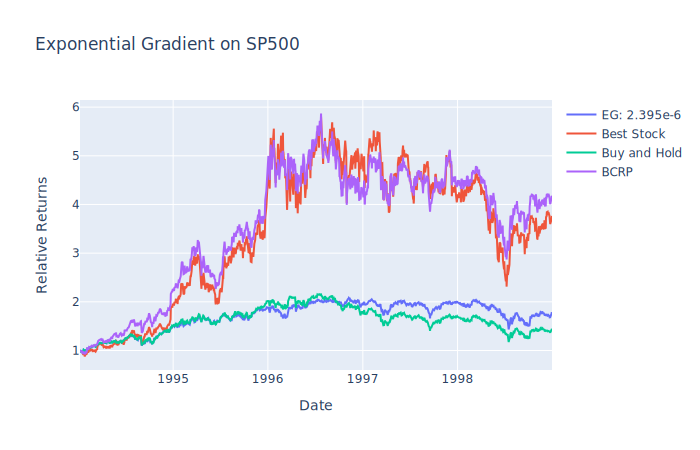

In [83]:
fig = go.Figure(); idx = tse_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=sp500_small_eta_list[sp500_small_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 2.395e-6"))
fig.add_trace(go.Scatter(x=idx, y=sp500_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=sp500_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=sp500_bcrp.portfolio_return['Returns'], name="BCRP"))
fig.update_layout(title='Exponential Gradient on SP500', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

SP500 during this time returns are only marginally better for Exponential Gradient compared to a simple Buy and Hold strategy. As seen with the Best Stock and Best Constant Rebalanced Portfolio, no one stock was dominant during this period with most stocks underperforming.

We see another example of a lack of a clear direction and continuous momentum affecting general portfolio returns.

## MSCI: 1998-2003

In [84]:
msci.tail(3)

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-21,581.392916,683.811303,1013.110604,1344.400758,10364.108501,416.329214,1448.298495,1588.740842,10181.002893,152.589494,...,2861.091981,161.992536,1631.854348,59.551533,2898.845186,289.943628,5996.494228,5729.337370,820.542785,2608.716015
2020-04-22,583.727898,704.832919,1020.682569,1382.745761,10388.209613,429.808850,1460.761507,1608.447299,10210.902283,156.841081,...,2930.770175,159.844927,1619.443584,60.773371,2895.229087,293.517799,6166.523111,5774.674583,842.396712,2669.372691
2020-04-23,590.102820,729.285719,1044.098476,1390.229972,10519.731506,434.347830,1475.563583,1624.477846,10254.069670,157.861220,...,2934.834695,161.938275,1669.657666,60.942110,2899.756263,295.120247,6274.965618,5757.703898,854.816085,2668.272058


#### Best Stock Analysis

In [85]:
msci_beststock = BestStock()
msci_beststock.allocate(msci)
display(msci_beststock.all_weights.iloc[-1].to_frame().T)
display(msci.iloc[-1].to_frame().T)

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
2020-04-23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
2020-04-23,590.10282,729.285719,1044.098476,1390.229972,10519.731506,434.34783,1475.563583,1624.477846,10254.06967,157.86122,...,2934.834695,161.938275,1669.657666,60.94211,2899.756263,295.120247,6274.965618,5757.703898,854.816085,2668.272058


In [87]:
data = 'MSCI'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    msci_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    msci_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    msci_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    msci_large_eta_optuna = pickle.load(f)

#### Hyperparameter Tuning

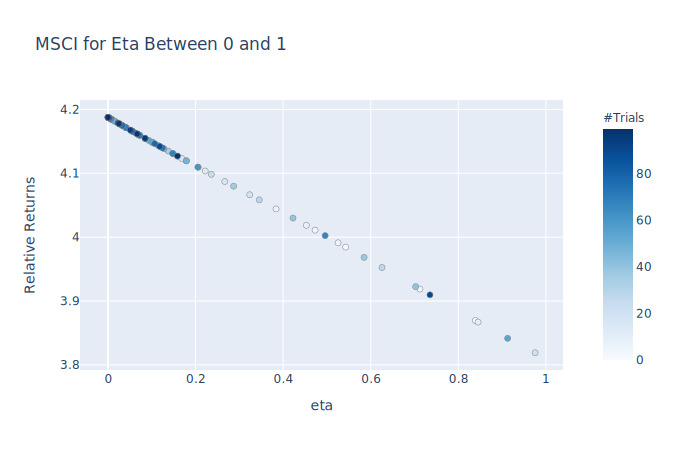

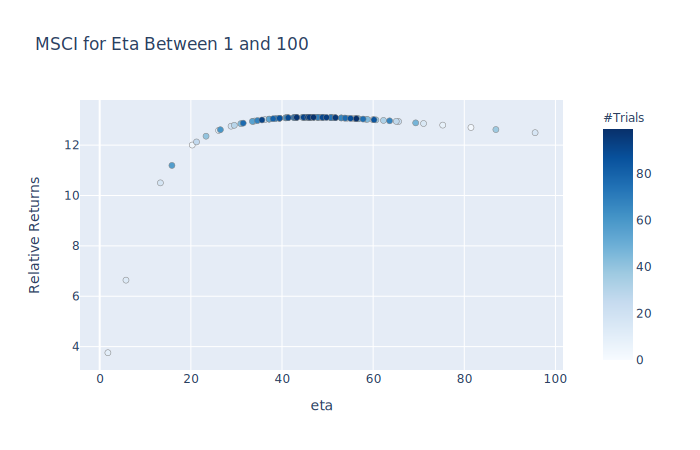

In [88]:
fig = optuna.visualization.plot_slice(msci_small_eta_optuna)
fig.update_layout(title_text="MSCI for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()
fig = optuna.visualization.plot_slice(msci_large_eta_optuna)
fig.update_layout(title_text="MSCI for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

#### Best Parameters

In [89]:
print("Best parameter: ", msci_large_eta_optuna.best_params['eta'])
print("Best returns: ", msci_large_eta_optuna.best_trial.value)
print("Best trial number: ", msci_large_eta_optuna.best_trial.number)

Best parameter:  46.25850376593418
Best returns:  13.106872733587059
Best trial number:  51


#### Benchmarks Comparison

In [90]:
msci_bah = BuyAndHold(); msci_bah.allocate(msci)
msci_bcrp = BestConstantRebalancedPortfolio(); msci_bcrp.allocate(msci)

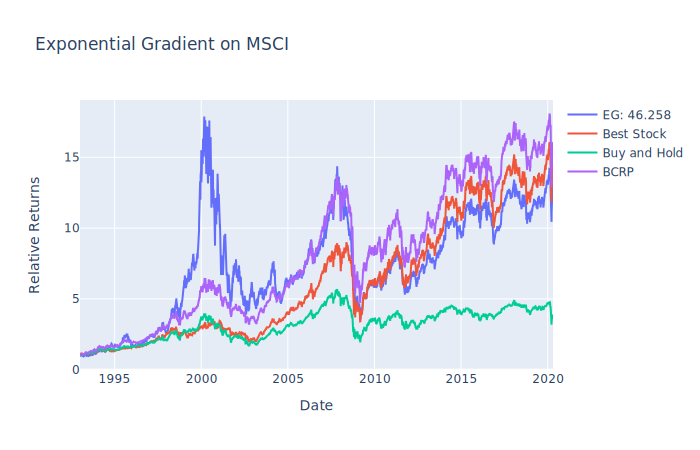

In [91]:
fig = go.Figure(); idx = msci_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=msci_large_eta_list[msci_large_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 46.258"))
fig.add_trace(go.Scatter(x=idx, y=msci_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=msci_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=msci_bcrp.portfolio_return['Returns'], name="BCRP"))
fig.update_layout(title='Exponential Gradient on MSCI', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

For the MSCI dataset, we see the dominance of EG near the 2000's. Primarily because of the rapid increase for Finland from the late 1990s, Exponential Gradient captured and put all the weights onto the performing asset. If there is an asset that performs far better for a long period, Exponential Gradient is effective.

We also have a different ideal $\eta$ value compared to Helmbold's uncovering. Helmbold's 0.05 eta value is valid for a market that all performs well. However, in the case of MSCI where there are drastic movements, larger values of $\eta$ is needed to capture the momentum.

## US Equity: 2011-2020

In [92]:
us_equity.tail(3)

,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-23,275.029999,93.940002,232.490005,2399.449951,82.459999,21.870001,278750.0,42.459999,112.910004,36.090000,...,119.400002,71.779999,73.809998,16.520000,29.500000,99.449997,33.369999,26.530001,128.529999,43.450001
2020-04-24,282.970001,94.059998,236.279999,2410.219971,83.169998,22.180000,279460.0,43.099998,114.040001,37.160000,...,118.779999,73.669998,76.040001,16.110001,29.709999,100.180000,34.000000,26.920000,129.440002,43.730000
2020-04-27,283.170013,94.949997,242.429993,2376.000000,85.059998,23.469999,281264.0,46.560001,115.199997,38.209999,...,117.449997,74.919998,75.980003,16.049999,30.540001,102.550003,35.880001,28.410000,128.300003,43.939999


#### Best Stock Analysis

In [93]:
us_equity_beststock = BestStock()
us_equity_beststock.allocate(us_equity)
display(us_equity_beststock.all_weights.iloc[-1].to_frame().T)
display(us_equity.iloc[-1].to_frame().T)

,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
2020-04-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
2020-04-27,283.170013,94.949997,242.429993,2376.0,85.059998,23.469999,281264.0,46.560001,115.199997,38.209999,...,117.449997,74.919998,75.980003,16.049999,30.540001,102.550003,35.880001,28.41,128.300003,43.939999


In [94]:
data = 'equity'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    us_equity_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    us_equity_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    us_equity_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    us_equity_large_eta_optuna = pickle.load(f)

#### Hyperparameter Tuning

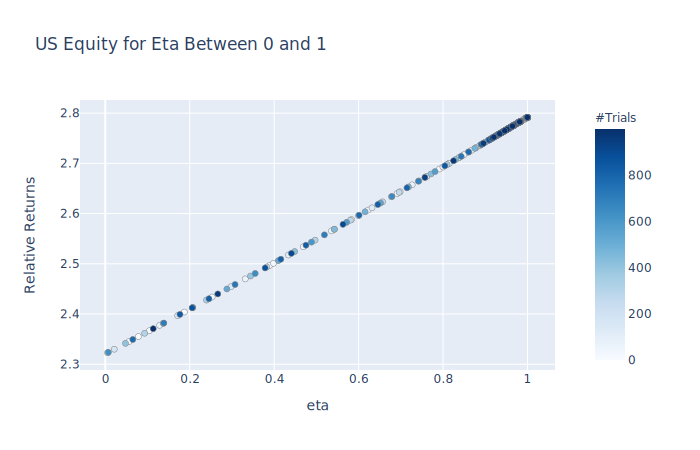

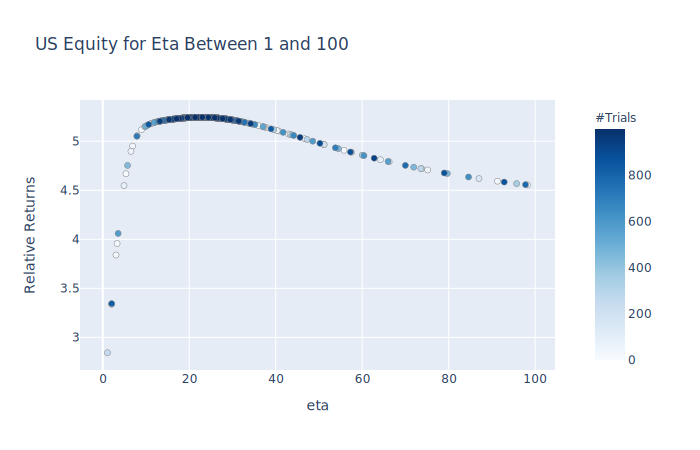

In [95]:
fig = optuna.visualization.plot_slice(us_equity_small_eta_optuna)
fig.update_layout(title_text="US Equity for Eta Between 0 and 1", yaxis_title_text="Relative Returns")
fig.show()
fig = optuna.visualization.plot_slice(us_equity_large_eta_optuna)
fig.update_layout(title_text="US Equity for Eta Between 1 and 100", yaxis_title_text="Relative Returns")
fig.show()

#### Best Parameters

In [96]:
print("Best parameter: ", us_equity_large_eta_optuna.best_params['eta'])
print("Best returns: ", us_equity_large_eta_optuna.best_trial.value)
print("Best trial number: ", us_equity_large_eta_optuna.best_trial.number)

Best parameter:  22.67681684948512
Best returns:  5.244109792255035
Best trial number:  162


#### Benchmarks Comparison

In [97]:
us_equity_bah = BuyAndHold()
us_equity_bah.allocate(us_equity)
us_equity_bcrp = BestConstantRebalancedPortfolio()
us_equity_bcrp.allocate(us_equity)

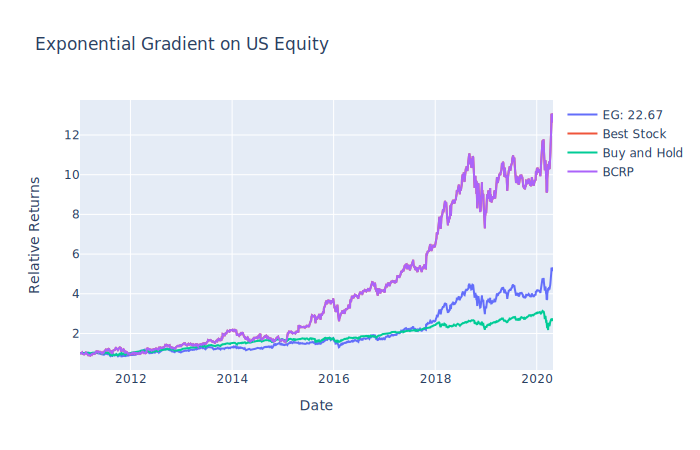

In [98]:
fig = go.Figure(); idx = us_equity_bah.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=us_equity_large_eta_list[us_equity_large_eta_optuna.best_trial.number].portfolio_return['Returns'], name="EG: 22.67"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_beststock.portfolio_return['Returns'], name="Best Stock"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=us_equity_bcrp.portfolio_return['Returns'], name="BCRP"))
fig.update_layout(title='Exponential Gradient on US Equity', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

Lastly, US Equity also shows an interesting example of Exponential Gradient outperforming the Buy and Hold. Starting from 2018, the gap between the benchmarks becomes larger as Exponential Gradient catches onto the Amazon momentum.

For this data, $\eta$ of 22.67 was ideal. This is another case where a higher $\eta$ was more optimal than a lower one. The higher $\eta$ value allows the strategy to quickly change directions if an asset is underperforming.

## Conclusion

Through this notebook, we were able to explore one of the functionalities of MlFinLab's newest Online Portfolio Selection module. Readers were exposed to a basic introduction to the exponential gradient strategy and will be able to replicate results using the simple methods of the new module.

The next notebook will focus on Momentum strategy, Follow the Leader/Regularized Leader.

If you enjoyed reading this please remember to leave us a star on [GitHub](https://github.com/hudson-and-thames) and join our [Slack](https://join.slack.com/t/mlfinlab/shared_invite/zt-c62u9gpz-VFc13j6da~UVg3DkV7~RjQ) channel to ask us any questions!